### Problem:
In our data analysis, we encountered inconsistencies in the calculation of DC magnitudes, particularly when assessing the presence of a source behind each data point. The original method for computing DC magnitudes didn't account for variations in source detection between different data points, leading to inaccuracies in the results.

In fact, the original method simply takes the first value of the distance to the nearest source in the reference image. However, in some instances (one of which we examine here), the ZTF data detects two different nearest sources—one for the red filter and another for the green filter.
This issue could potentially arise from the estimation of noise levels in the red and green filters.

### Solution:
To address this issue, we implemented a new approach to compute DC magnitudes. First, we modified the existing function to include a new variable called `is_Source`, which allows for flexibility in source detection. We then incorporated this variable into the DC magnitude calculation process, ensuring that the computation adapts to the presence or absence of a detected source for each data point. By making these adjustments, we aimed to improve the accuracy and reliability of our DC magnitude calculations, resulting in more robust data analysis outcomes.

### The explanation follows below :

#


In [1]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

#

In [2]:
oid = 'ZTF18acckcza'

r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': oid,
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_magpsf = pd.read_json(io.BytesIO(r.content))


#

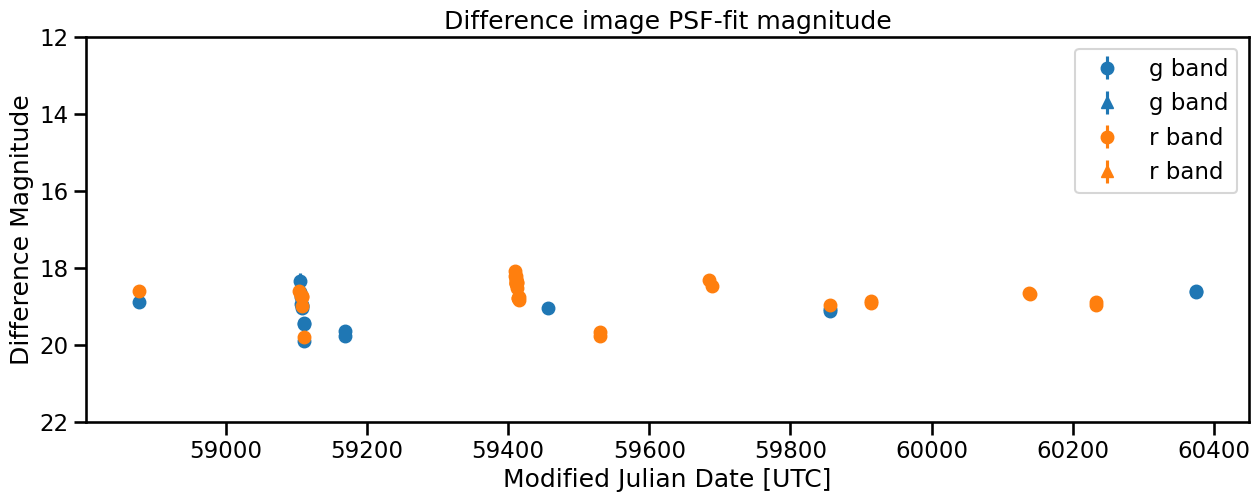

In [3]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt
    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid' 
    maskneg = pdf_magpsf['i:isdiffpos'] == 't' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    maskpos = pdf_magpsf['i:isdiffpos'] == 'f' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    
    

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



#

#

# We have detected a bug in the functionality related to computing DC magnitude.

### We will start with the original case, we take the first value of ['i:distnr'] to test is there is a source behind. 
This value is for a green data.

In [4]:
# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
pdf_magpsf_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

pdf_magpsf_valid['mjd'] = pdf_magpsf_valid['i:jd'] - 2400000.5


isSource = is_source_behind(
    pdf_magpsf_valid['i:distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
    pdf_magpsf_valid['i:mag_dc_origin'] = mag_dc
    pdf_magpsf_valid['i:err_dc_origin'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    pdf_magpsf_valid['i:mag_dc_origin'] = pdf_magpsf_valid['i:magpsf']
    pdf_magpsf_valid['i:err_dc_origin'] = pdf_magpsf_valid['i:sigmapsf']



No source found -- keeping PSF fit magnitude


So, we find that there is no source behind. Therefore, the values of DC mag `mag_dc` (_origin here) directly take the values of `magpsf`.

#

##### Now we try another value of ['i:distnr']. Let's take the third (which corresponds to red data).

In [5]:
isSource = is_source_behind(
    pdf_magpsf_valid['i:distnr'].values[2] # We made a change to this. 
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
    pdf_magpsf_valid['i:mag_dc_origin2'] = mag_dc
    pdf_magpsf_valid['i:err_dc_origin2'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    pdf_magpsf_valid['i:mag_dc_origin2'] = pdf_magpsf_valid['i:magpsf']
    pdf_magpsf_valid['i:err_dc_origin2'] = pdf_magpsf_valid['i:sigmapsf']



It looks like there is a source behind. Lets compute the DC magnitude instead.


### Here we find that there is a source behind, so the values of DC mag `mag_dc` (_origin_2 from here) are computed using the `dc_mag` function.

#

#

#

## To understand what's happening, let's plot the distance to the nearest source in the reference image to illustrate the variance of this distance between red and green filters.
We also plot the average value of ['i:distnr'] for each filter.
###### Additionally, we utilize the function `is_source_behind` to detect for each value of ['i:distnr'] if there is a source estimated by the `is_source_behind` function.

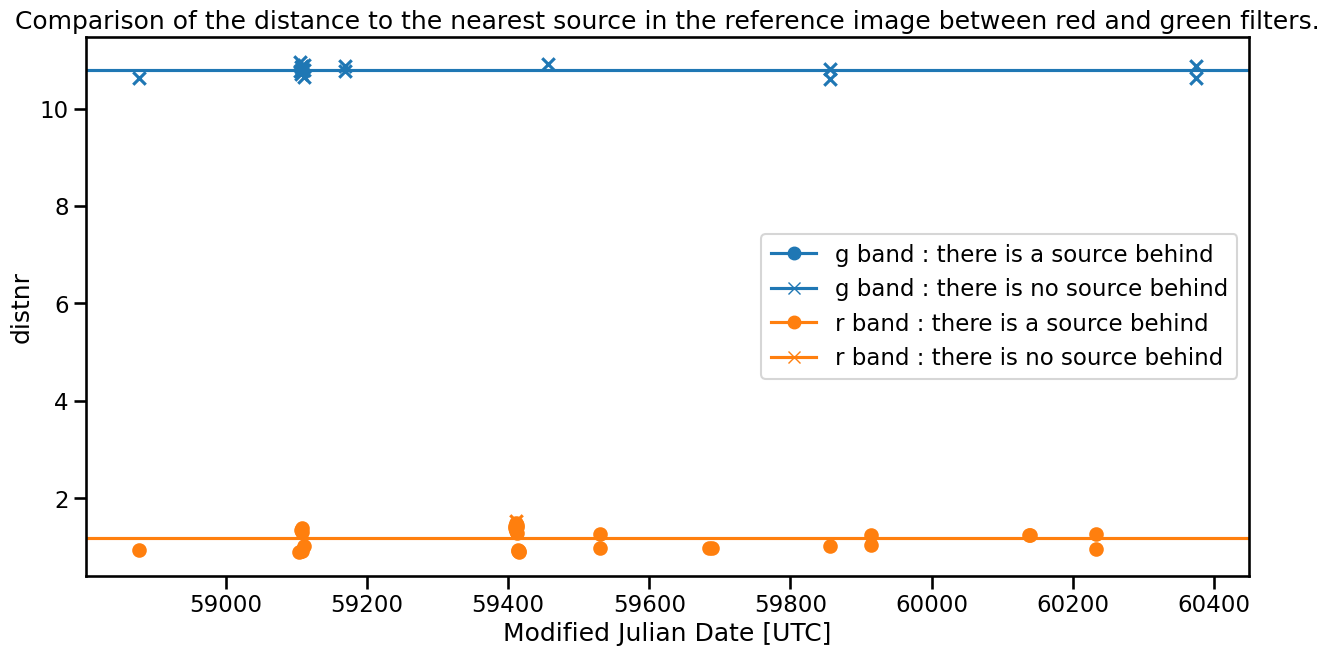

In [6]:
# Take only valid measurements


fig = plt.figure(figsize=(15, 7))
for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.plot([], [], color=colordic[filt], marker='o', label=f'{filtdic[filt]} band : there is a source behind')
    plt.plot([], [], color=colordic[filt], marker='x', label=f'{filtdic[filt]} band : there is no source behind')

    for idx, row in pdf_magpsf_valid[maskFilt].iterrows():
        # Determine marker based on is_Source for each point
        marker = 'o' if is_source_behind(row['i:distnr']) else 'x' 
        
        plt.scatter(row['mjd'],
                    row['i:distnr'], marker=marker, color=colordic[filt])

    plt.axhline(pdf_magpsf_valid[maskFilt]['i:distnr'].mean(), color=colordic[filt])
    
plt.legend()
plt.title('Comparison of the distance to the nearest source in the reference image between red and green filters.')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('distnr');

### As you can see here, the distance to the nearest source between red and green filters differs significantly. 
This indicates that something was detected in the red filter that was not detected in the green filter. Additionally, we observe that around MJD ~ 59420, a red data point estimated the presence of a source, while all other red data points did not.

#

#

#### We modified the function `dc_mag` used in the tutorial. It is placed in the `fink_utils` package folder photometry, within the file conversion.py.

Note: Here, we import `apparent_flux` from the same file. 

We added the variable `is_Source` with a default value of "True". This ensures that the modification doesn't require changes in all files(unless specifically desired for a particular file).

###### The concept of the new function is to compute the DC magnitude for each point based on the value of `['i:distnr']` of that point.

In [8]:
from typing import Tuple
from fink_utils.photometry.conversion import apparent_flux

def dc_mag(
    magpsf: float,
    sigmapsf: float,
    magnr: float,
    sigmagnr: float,
    isdiffpos: int,
    is_Source: bool = True
) -> Tuple[float, float]:
    """Compute apparent magnitude from difference magnitude supplied by ZTF
    Implemented according to p.107 of the ZTF Science Data System Explanatory Supplement
    https://irsa.ipac.caltech.edu/data/ZTF/docs/ztf_explanatory_supplement.pdf

    Parameters
    ----------
    magpsf,sigmapsf
        magnitude from PSF-fit photometry, and 1-sigma error
    magnr,sigmagnr
        magnitude of nearest source in reference image PSF-catalog
        within 30 arcsec and 1-sigma error
    isdiffpos
        t or 1 => candidate is from positive (sci minus ref) subtraction
        f or 0 => candidate is from negative (ref minus sci) subtraction

    Returns
    --------
    dc_mag: float
        Apparent magnitude
    dc_sigmag: float
        Error on apparent magnitude
    """
    
    if is_Source: 
    
        dc_flux, dc_sigflux = apparent_flux(
            magpsf, sigmapsf, magnr, sigmagnr, isdiffpos, jansky=False
        )

        # apparent mag and its error from fluxes
        dc_mag = -2.5 * np.log10(dc_flux)
        dc_sigmag = dc_sigflux / dc_flux * 1.0857
        
        return dc_mag, dc_sigmag

    return magpsf, sigmapsf

#

##### We create a column for the `is_Source` test to facilitate the computation.

In [9]:
pdf_magpsf_valid['is_Source'] = is_source_behind(pdf_magpsf_valid['i:distnr'])

#

#### Now we incorporate this column into the function used to compute `mag_dc` without utilizing the `is_source` test.

In [10]:
mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values,
                pdf_magpsf_valid['is_Source'].astype(bool).values

            )
        ]
    )
    
pdf_magpsf_valid['i:mag_dc_new'] = mag_dc
pdf_magpsf_valid['i:err_dc_new'] = err_dc

#

### Here, we plot the difference in magnitude calculated with the new function (tested on each data point) and the original function.

Text(0, 0.5, 'Difference (new - original)')

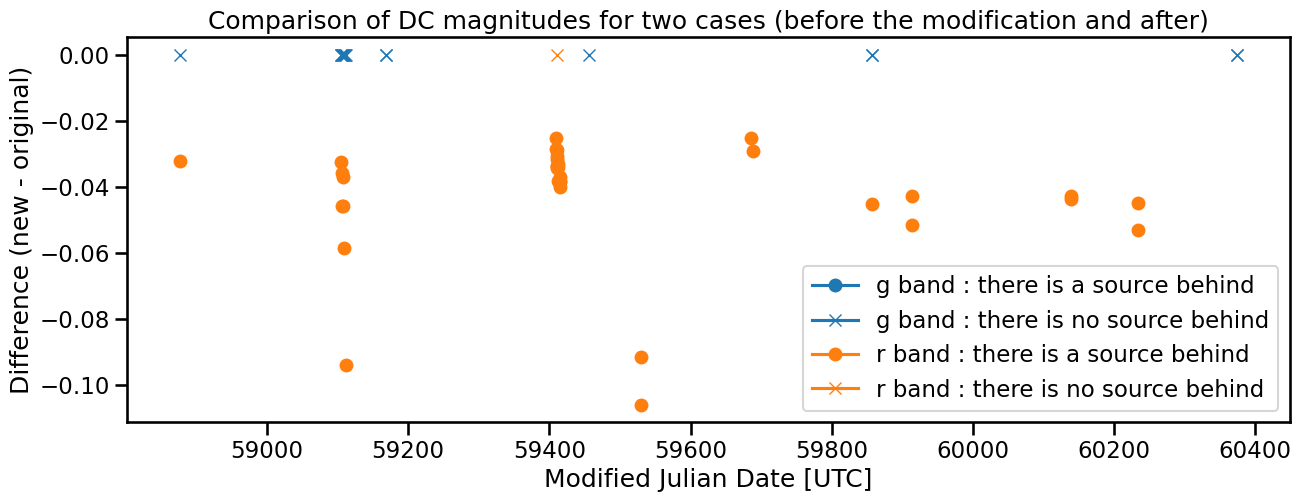

In [12]:
fig = plt.figure(figsize=(15, 5))

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.plot([], [], color=colordic[filt], marker='o', label=f'{filtdic[filt]} band : there is a source behind')
    plt.plot([], [], color=colordic[filt], marker='x', label=f'{filtdic[filt]} band : there is no source behind')

    for idx, row in pdf_magpsf_valid[maskFilt].iterrows():
        # Determine marker based on is_Source for each point
        marker = 'o' if row['is_Source'] else 'x' 
  
        plt.plot(
                row['i:jd'] - 2400000.5,
                row['i:mag_dc_new'] - row['i:mag_dc_origin'],
                marker=marker, 
                color=colordic[filt]
        )
plt.legend()
plt.title('Comparison of DC magnitudes for two cases (before the modification and after)')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference (new - original)')

#

#